In [1]:
import numpy as np
from dgamod import *
import cmath as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import configparser
import sys
import os
import matplotlib.animation as animation
from drl_grams import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

mpl.rcParams.update({'font.size': 12})
plt.rcParams['axes.axisbelow'] = True
%matplotlib widget
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrkmyc')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "g", "r", 'k','y' , 'm','tab:orange', 'tab:cyan', 'tab:brown', 'slategrey', 'deeppink' ]) 

#### 54 Jornadas Argentinas de Informática e investigación Operativa

# Optimización de la Transmisión de Estados Cuánticos en Cadenas de Qubits usando Deep Reinforcement Learning y Algoritmos Genéticos

Sofía Perón Santana

--- 

Este notebook resume los resultados y gráficos presentados en el artículo *Optimización de la Transmisión de Estados Cuánticos en Cadenas de Qubits usando Deep Reinforcement Learning y Algoritmos Genéticos* presentado en la 54 JAIIO. En el mismo se comparan los dos enfoques mencionados y se cuantifica su desempeño para la optimización de transmisiones de estados cuánticos en cadenas de qubits. 

### Algoritmos genéticos vs DRL

El primer gráfico presentado muestra las fidelidades máximas y medias logradas con ambos métodos para distintos largos de cadenas de qubits. Los directorios con los resultados crudos se incluyen en este repositorio en sus respectivos directorios `drl_preliminary_results` y `ga_preliminary_results`. Se busca resumir algunas herramientas útiles para visualizar los datos obtenidos. 

In [2]:
# Extracción de datos de fidelidades de los resultados preliminares del DRL
# Cada directorio contiene los resultados para el entrenamiento de un largo de cadena específico
# Se recuperan los 10 valores de fidelidad más altos para cada largo de cadena separados durante el entrenamiento

path = 'drl_preliminary_results/'

dimensions = [8,12,16,20,24,32]
fidelities = pd.DataFrame()

fidelities = pd.DataFrame(columns=['chain_length', 'method', 'fid'])

for dimension in dimensions:
    directory = path + f'n{dimension}_og_zhangn{dimension}_off_size120'
    best_fids = np.loadtxt(directory + '/best_fidelities.txt', dtype=np.float32)
    for fid in best_fids:
        fidelities = pd.concat([fidelities, pd.DataFrame({'chain_length': [dimension], 'method': ['zhang'], 'fid': [fid]})], ignore_index=True)

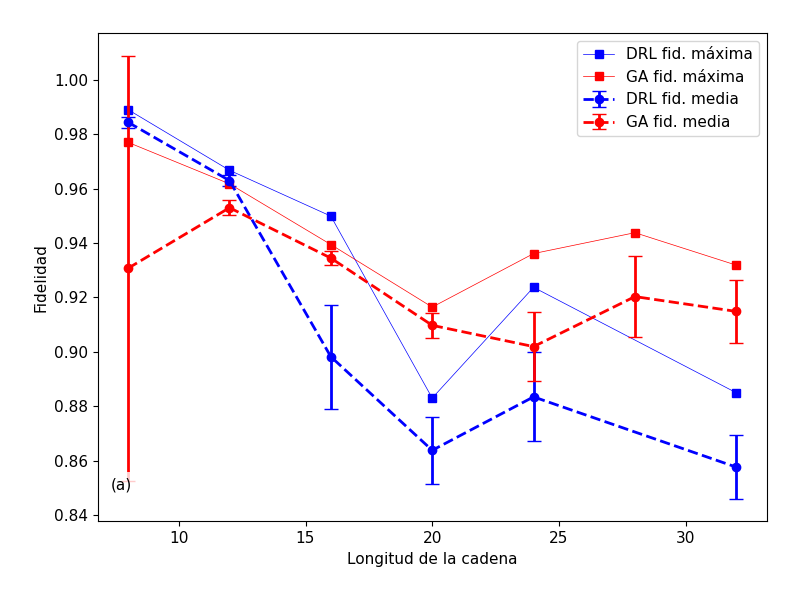

In [20]:
plt.figure(figsize=(8, 6))

# DRL results
grouped_drl = fidelities.groupby('chain_length')['fid']
mean_drl = grouped_drl.mean()
std_drl = grouped_drl.std()
max_drl = grouped_drl.max()

plt.errorbar(dimensions, mean_drl, yerr=std_drl, fmt='o--', label='DRL fid. media', color='blue', capsize=5)
plt.plot(dimensions, max_drl, 's-', color='blue', label='DRL fid. máxima', linewidth=0.5)

# GA results (only up to chain_length 32)
ga_results['chain_length'] = pd.to_numeric(ga_results['chain_length'], errors='coerce')
ga_results['fid'] = pd.to_numeric(ga_results['fid'], errors='coerce')
ga_results_32 = ga_results[ga_results['chain_length'] <= 32]
ga_grouped = ga_results_32.groupby('chain_length')['fid']
mean_ga = ga_grouped.mean()
std_ga = ga_grouped.std()
max_ga = ga_grouped.max()
ga_dims = sorted(ga_results_32['chain_length'].unique())

plt.errorbar(ga_dims, mean_ga, yerr=std_ga, fmt='o--', label='GA fid. media', color='red', capsize=5)
plt.plot(ga_dims, max_ga, 's-', color='red', label='GA fid. máxima', linewidth=0.5)

plt.xlabel('Longitud de la cadena', fontsize=fs)
plt.ylabel('Fidelidad', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout(pad=2.0)
plt.legend(fontsize=fs)
plt.text(0.02, 0.09, '(a)', transform=plt.gca().transAxes, fontsize=fs, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.savefig('zhang_drl_ga_fidelidades.png', dpi=1600, bbox_inches='tight')


In [17]:
samples = np.arange(0,10,1)
n = 16
ga_sequences = uniformize_data('ga',**{'directory': f'genetic_algorithm_results/rb_zhang/n{n}/', 'n':n})
zhang_sequences = uniformize_data('zhang',**{'file' : f'drl_preliminary_results/n{n}_og_zhangn{n}_off_size120/best_action_sequences.txt'})

In [18]:
def fid_evolution(
    action_sequence, nh, dt=0.15, b=100, label="", actions="original", add_natural=False
):

    action_sequence = [int(x) for x in action_sequence]
    t_steps = len(action_sequence) + 1

    # generar propagadores
    actions = action_selector(actions, b, nh)
    propagators = gen_props(actions, nh, dt)
    times = np.arange(0, t_steps, 1)

    # definicion del estado inicial e inicializacion de estados forzado y natural

    initial_state = np.zeros(nh, dtype=np.complex_)
    initial_state[0] = 1.0

    # inicializacion de estado forzado
    forced_state = initial_state

    # almacenar evolucion natural y evolucion forzada
    forced_evol = [state_fidelity(forced_state)]

    for action in action_sequence:

        forced_state = calculate_next_state(forced_state, action, propagators)
        forced_evol.append(state_fidelity(forced_state))

    max_forced = np.max(forced_evol)
    max_time = np.argmax(forced_evol)

    free_state = initial_state

    if add_natural:
        natural_evol = [state_fidelity(free_state)]

        nat_sequence = np.zeros(int(t_steps - 1), dtype=int)

        for action in nat_sequence:

            free_state = calculate_next_state(free_state, 0, propagators)
            natural_evol.append(state_fidelity(free_state))

        max_natural = np.max(natural_evol)



        return forced_evol,natural_evol
    
    else:
    
        return forced_evol

/home/sofi/miniconda3/envs/drlenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(array([0.  , 0.5 , 0.95]), [Text(1, 0, ''), Text(1, 0, ''), Text(1, 0, '')])

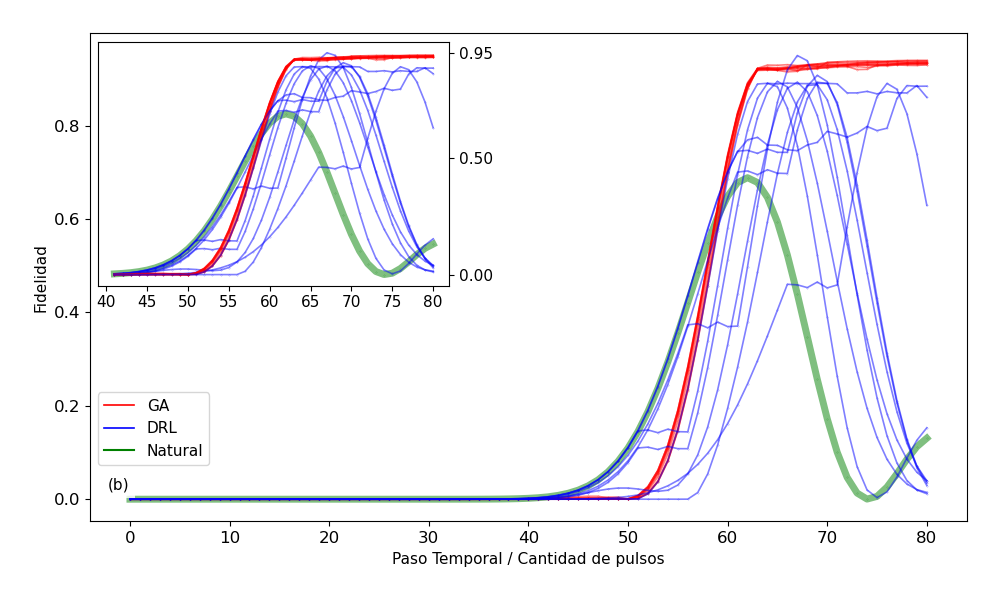

In [19]:
plt.figure(figsize=(10, 6))

for sample in samples:
    forced_evol, natural_evol = fid_evolution(ga_sequences[sample][:], n, dt=0.15, b=100, label="", actions="original", add_natural=True)
    plt.plot(forced_evol, '-o', label=f'GA {sample}', color='red', alpha=0.5, linewidth=1.2, markersize=0.2)
for sample in samples:
    forced_evol, natural_evol = fid_evolution(zhang_sequences[sample][:], n, dt=0.15, b=100, label="", actions="original", add_natural=True)
    plt.plot(forced_evol, '-o', label=f'GA {sample}', color='blue', alpha=0.5, linewidth=1.2, markersize=0.2)

plt.plot(natural_evol, '-o', label='Natural', color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder = -2)
# Mover etiquetas de los ejes al eje principal
plt.xlabel('Paso Temporal / Cantidad de pulsos', fontsize=fs)
plt.ylabel('Fidelidad', fontsize=fs)
# Create a personalized legend

legend_elements = [
    Line2D([0], [0], color='red', lw=1.2, label='GA'),
    Line2D([0], [0], color='blue', lw=1.2, label='DRL'),
    Line2D([0], [0], color='green', lw=1.5, label='Natural')
]
plt.legend(handles=legend_elements, fontsize=fs, loc='lower left', bbox_to_anchor=(0, 0.1))
plt.text(0.02, 0.09, '(b)', transform=plt.gca().transAxes, fontsize=fs, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Agregar inset
ax_inset = inset_axes(plt.gca(), width="40%", height="50%", loc="upper left")
ax_inset.plot(range(len(forced_evol))[int(-2.5*n):],natural_evol[int(-2.5*n):], '-o', label='Natural', color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder = -2)
for sample in samples:
    forced_evol, natural_evol = fid_evolution(ga_sequences[sample][:], n, dt=0.15, b=100, label="", actions="original", add_natural=True)
    ax_inset.plot(range(len(forced_evol))[int(-2.5*n):], forced_evol[int(-2.5*n):], '-o', color='red', alpha=0.5, linewidth=1.2, markersize=0.2)
    forced_evol, natural_evol = fid_evolution(zhang_sequences[sample][:], n, dt=0.15, b=100, label="", actions="original", add_natural=True)
    ax_inset.plot(range(len(forced_evol))[int(-2.5*n):], forced_evol[int(-2.5*n):], '-o', color='blue', alpha=0.5, linewidth=1.2, markersize=0.2)
    ax_inset.yaxis.tick_right()
    ax_inset.tick_params(axis='both', which='major', labelsize=fs - 6)
# ax_inset.set_xticks([60,70,80])
ax_inset.set_yticks([0., 0.5, 0.95])
ax_inset.tick_params(axis='x', labelsize=fs - 6)
ax_inset.tick_params(axis='y', labelsize=fs - 6)    

plt.tight_layout(pad=2.0)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
